<a href="https://colab.research.google.com/github/Yaninast/MachineLearning-/blob/master/MSDS_453_Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Load required packages 

In [4]:
!pip install pyLDAvis

     |████████████████████████████████| 1.6MB 6.4MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97711 sha256=7551df99bf4ee000518f468c3cb5b290400f9be115ee29ada7957d32136585ce
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
Successfully built pyLDAvis


In [5]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Sat Sep 29 21:06:55 2018

@author: paulhuynh
"""

###############################################################################
### packages required to run code.  Make sure to install all required packages.
###############################################################################
import re,string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer,  WordNetLemmatizer


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.manifold import MDS


from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold

import pandas as pd
import os

from gensim.models import Word2Vec,LdaMulticore, TfidfModel
from gensim import corpora


from gensim.models.doc2vec import Doc2Vec, TaggedDocument


import numpy as np

import nltk
nltk.download('stopwords')
nltk.download('wordnet')


import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

   

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Function to process documents

In [0]:
def clean_doc(doc): 
    #split document into individual words
    tokens=doc.split()
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # remove remaining tokens that are not alphabetic
    tokens = [word for word in tokens if word.isalpha()]
    # filter out short tokens
    tokens = [word for word in tokens if len(word) > 4]
    #lowercase all words
    tokens = [word.lower() for word in tokens]
    # filter out stop words
    more_stop_words = ['february','therefore','cant','didnt','doesnt','dont','goes','isnt','hes',\
        'shes','thats','theres','theyre','wont','youll','youre','youve', 'br'\
        've', 're', 'vs', 'from', 'subject', 're', 'edu', 'use', 'percent', 'saturday', 'friday', 'monday','theyve','definetely','wednesday', 'thursday','perdue', 'three','whether', 'without'] 
    stop_words = set(stopwords.words('english') + more_stop_words)
    tokens = [w for w in tokens if not w in stop_words]         
    # word stemming    
    # ps=PorterStemmer()
    # tokens=[ps.stem(word) for word in tokens]
    # word lemmatizing 
    lm = WordNetLemmatizer()
    tokens=[lm.lemmatize(word) for word in tokens]      
    return tokens
  
  ## A custom list if we really wanted to
     #vec = CountVectorizer(tokenizer=textblob_tokenizer, stop_words=['it', 'and', 'is', 'a'])
     #matrix = vec.fit_transform(texts)
     #pd.DataFrame(matrix.toarray(), columns=vec.get_feature_names())

# Function to process documents

In [0]:
def One_Hot(variable):
    LE=LabelEncoder()
    LE.fit(variable)
    Label1=LE.transform(variable)
    OHE=OneHotEncoder()
    labels=OHE.fit_transform(Label1.reshape(-1,1)).toarray()
    return labels, LE, OHE

#Processing text into lists

In [9]:
#set working Directory to where class corpus is saved.
#os.chdir('/Users/paulhuynh/Documents/School/2019 Winter/453 - Maren/2019 Winter - MSDS 453 - Class Corpus/')

from google.colab import files 
uploaded = files.upload()


#read in class corpus csv into python
data=pd.read_csv('2019_Summer_435_Class_Corpus.csv')
data.head()
data.describe()


Saving 2019_Summer_435_Class_Corpus.csv to 2019_Summer_435_Class_Corpus.csv
Saving corpus_test_bert_tsv.csv to corpus_test_bert_tsv.csv


,Unnamed: 0
count,61.000000
mean,30.000000
std,17.752934
min,0.000000
25%,15.000000
50%,30.000000
75%,45.000000
max,60.000000


In [0]:
#create empty list to store text documents titles
titles=[]

#for loop which appends the DSI title to the titles list
for i in range(0,len(data)):
    temp_text=data['DSI_Title'].iloc[i]
    titles.append(temp_text)

#create empty list to store text documents
text_body=[]

#for loop which appends the text to the text_body list
for i in range(0,len(data)):
    temp_text=data['Text'].iloc[i]
    text_body.append(temp_text)

#Note: the text_body is the unprocessed list of documents read directly form 
#the csv.
    
#empty list to store processed documents
processed_text=[]
#for loop to process the text to the processed_text list
for i in text_body:
    text=clean_doc(i)
    processed_text.append(text)

#Note: the processed_text is the PROCESSED list of documents read directly form 
#the csv.  Note the list of words is separated by commas.


#stitch back together individual words to reform body of text
final_processed_text=[]

for i in processed_text:
    temp_DSI=i[0]
    for k in range(1,len(i)):
        temp_DSI=temp_DSI+' '+i[k]
    final_processed_text.append(temp_DSI)
    
#Note: We stitched the processed text together so the TFIDF vectorizer can work.
#Final section of code has 3 lists used.  2 of which are used for further processing.
#(1) text_body - unused, (2) processed_text (used in W2V), 
#(3) final_processed_text (used in TFIDF), and (4) DSI titles (used in TFIDF Matrix)


#Sklearn TFIDF 

In [0]:
#note the ngram_range will allow you to include multiple words within the TFIDF matrix
#Call Tfidf Vectorizer
Tfidf=TfidfVectorizer(ngram_range=(1,3), min_df = 0.03)

#fit the vectorizer using final processed documents.  The vectorizer requires the 
#stiched back together document.

TFIDF_matrix=Tfidf.fit_transform(final_processed_text)  


#creating datafram from TFIDF Matrix
matrix=pd.DataFrame(TFIDF_matrix.toarray(), columns=Tfidf.get_feature_names(), index=titles)


In [0]:
matrix.iloc[1].max() 
matrix[['asylum']].sort_values(by=['asylum'], axis =0, ascending = False)

,asylum
YS_Doc1_Trump_ Immigration_policy.docx,0.309588
YS_Doc2_Migrant_crisis .docx,0.192875
Trump-says-DHS.docx,0.100900
JL_Trump Administration Calls for Medicaid Overhaul Home Health Care News.docx,0.000000
Fed-Interest-Rates.docx,0.000000
RLS_Doc2_Trump-Iran-Policy_Trump-approved economic sanctions against Iran hurt average Iranians.docx,0.000000
Government Shutdown Unemployment Claims.docx,0.000000
The Real Problem with Immigration.docx,0.000000
Memo-Muller-Obstruction.docx,0.000000
Government Shutdown Across America.docx,0.000000


In [0]:
max_doc_TFIDF={}
for row, value in matrix.iterrows():
  max_doc_TFIDF[row]= value.sort_values(ascending = False)

max_doc_TFIDF['YS_Doc1_Trump_ Immigration_policy.docx']
max_doc_TFIDF['YS_Doc2_Migrant_crisis .docx']
  
    


max_TFIDF_DF_doc_1=pd.DataFrame(max_doc_TFIDF['YS_Doc1_Trump_ Immigration_policy.docx'])

max_TFIDF_DF_doc_1.columns=['TFIDF']

max_TFIDF_DF_doc_2=pd.DataFrame(max_doc_TFIDF['YS_Doc2_Migrant_crisis .docx'])

max_TFIDF_DF_doc_2.columns=['TFIDF']

average_TFIDF_doc_1 = max_TFIDF_DF_doc_1.mean()
average_TFIDF_doc_2 = max_TFIDF_DF_doc_2.mean()

max_TFIDF_DF_doc_1[max_TFIDF_DF_doc_1['TFIDF']>0.04]
max_TFIDF_DF_doc_1.mean()


TFIDF    0.00422
dtype: float64

In [0]:
max_TFIDF={}
for i in matrix.columns:
    max_TFIDF[i]=matrix[i].max()

max_TFIDF_DF=pd.DataFrame(max_TFIDF,index=[0]).transpose()

max_TFIDF_DF.columns=['TFIDF']

max_TFIDF_DF.sort_values(by=['TFIDF'],ascending = False)

,TFIDF
school,0.766275
nielsen,0.651959
morgan,0.613897
nuclear,0.496712
moore,0.486056
migrant,0.453192
european,0.449765
manafort,0.444468
unemployment,0.436003
russian,0.435673


# Explore TFIDF Values

In [0]:
###############################################################################
### Explore TFIDF Values
###############################################################################

average_TFIDF={}
for i in matrix.columns:
    average_TFIDF[i]=np.mean(matrix[i])

average_TFIDF_DF=pd.DataFrame(average_TFIDF,index=[0]).transpose()

average_TFIDF_DF.columns=['TFIDF']

#calculate Q1 and Q3 range
Q1=np.percentile(average_TFIDF_DF, 25)
Q3=np.percentile(average_TFIDF_DF, 75)
IQR = Q3 - Q1
outlier=Q3+(1.5*IQR)


#words that exceed the Q3+IQR*1.5
outlier_list=average_TFIDF_DF[average_TFIDF_DF['TFIDF']>=outlier]
outlier_list.sort_values(by = 'TFIDF', ascending = False)
average_TFIDF_DF.sort_values(by = 'TFIDF', ascending = False)
outlier_list_2=average_TFIDF_DF[average_TFIDF_DF['TFIDF']<=outlier]
outlier_list_2.sort_values(by = 'TFIDF', ascending = True)

#can export matrix to csv and explore further if necessary



In [0]:
outlier_list.loc['trump']

TFIDF    0.103949
Name: trump, dtype: float64

#Doc2Vec

In [0]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(final_processed_text)]
model = Doc2Vec(documents, vector_size=100, window=2, min_count=1, workers=4)

doc2vec_df=pd.DataFrame()
for i in range(0,len(processed_text)):
    vector=pd.DataFrame(model.infer_vector(processed_text[i])).transpose()
    doc2vec_df=pd.concat([doc2vec_df,vector], axis=0)

doc2vec_df=doc2vec_df.reset_index()

doc_titles={'title': titles}
t=pd.DataFrame(doc_titles)

doc2vec_df=pd.concat([doc2vec_df,t], axis=1)

doc2vec_df=doc2vec_df.drop('index', axis=1)

# Gensim Word2vec 

In [0]:
#Note, there are opportunities to use the word2vec matrix to determine words 
#which are similar.  Similar words can be used to create equivalent classes.  
#k-means is not used to group individual words using the Word2Vec output.

#word to vec
model_w2v = Word2Vec(processed_text, size=100, window=5, min_count=1, workers=4)

#join all processed DSI words into single list
processed_text_w2v=[]
for i in processed_text:
    for k in i:
        processed_text_w2v.append(k)

#obtian all the unique words from DSI
w2v_words=list(set(processed_text_w2v))

#can also use the get_feature_names() from TFIDF to get the list of words
#w2v_words=Tfidf.get_feature_names()

#empty dictionary to store words with vectors
w2v_vectors={}

#for loop to obtain weights for each word
for i in w2v_words:
    temp_vec=model_w2v.wv[i]
    w2v_vectors[i]=temp_vec

#create a final dataframe to view word vectors
w2v_df=pd.DataFrame(w2v_vectors).transpose()


#the following section runs applies the k-means algorithm on the TFIDF matrix.


In [0]:
import gensim

word2vec_path = "GoogleNews-vectors-negative300.bin.gz"
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


FileNotFoundError: ignored

# K Means Clustering - TFIDF

For n_clusters = 2 The average silhouette_score is : 0.36910277835773214
For n_clusters = 3 The average silhouette_score is : 0.40268297223516997
For n_clusters = 4 The average silhouette_score is : 0.40378515960325617
For n_clusters = 5 The average silhouette_score is : 0.38708515826621476
For n_clusters = 6 The average silhouette_score is : 0.3653842023041441
For n_clusters = 7 The average silhouette_score is : 0.35922965410502883
For n_clusters = 8 The average silhouette_score is : 0.3675658470822285
For n_clusters = 9 The average silhouette_score is : 0.35595875680610506
For n_clusters = 10 The average silhouette_score is : 0.3592414811638101


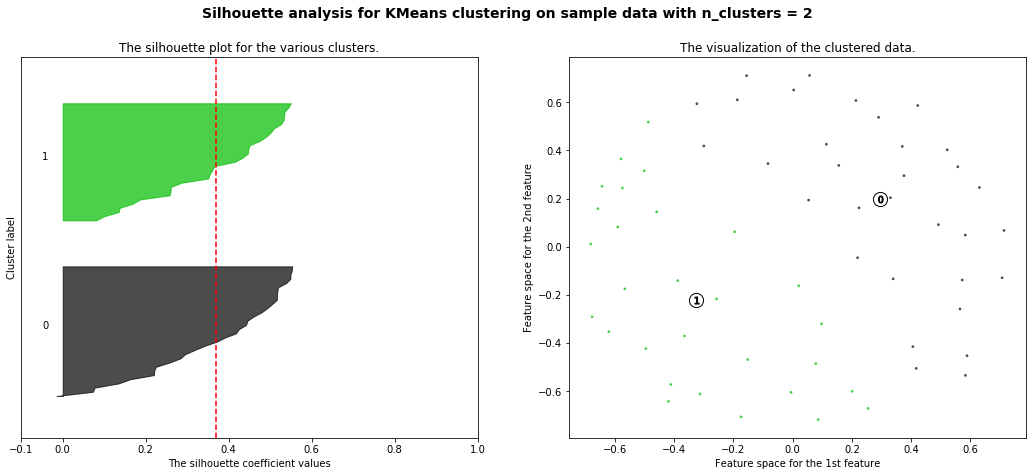

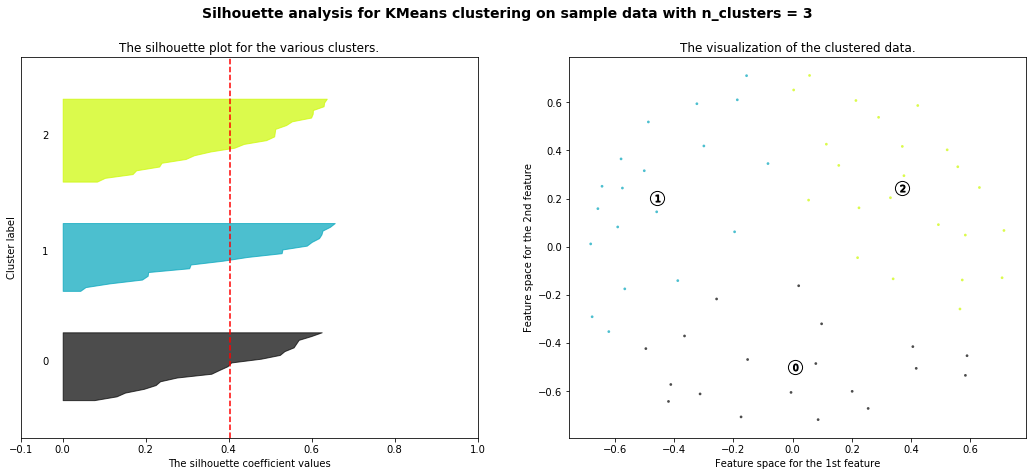

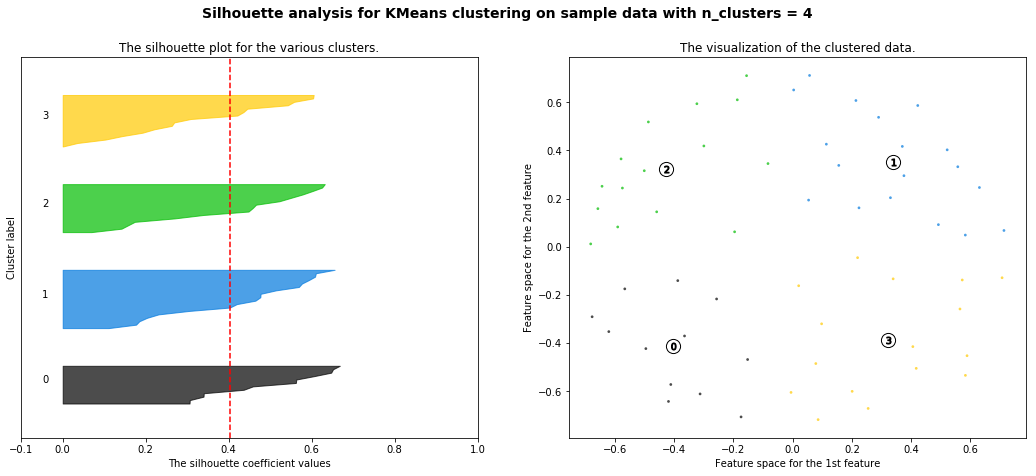

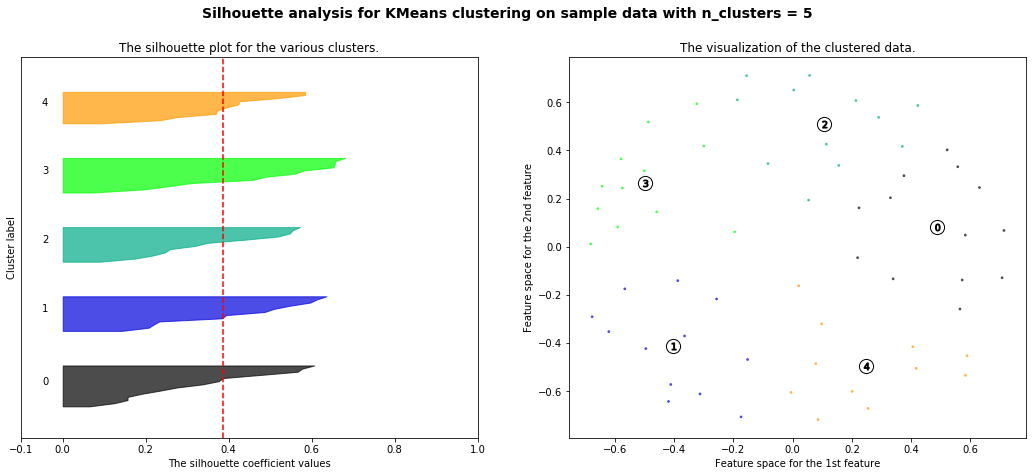

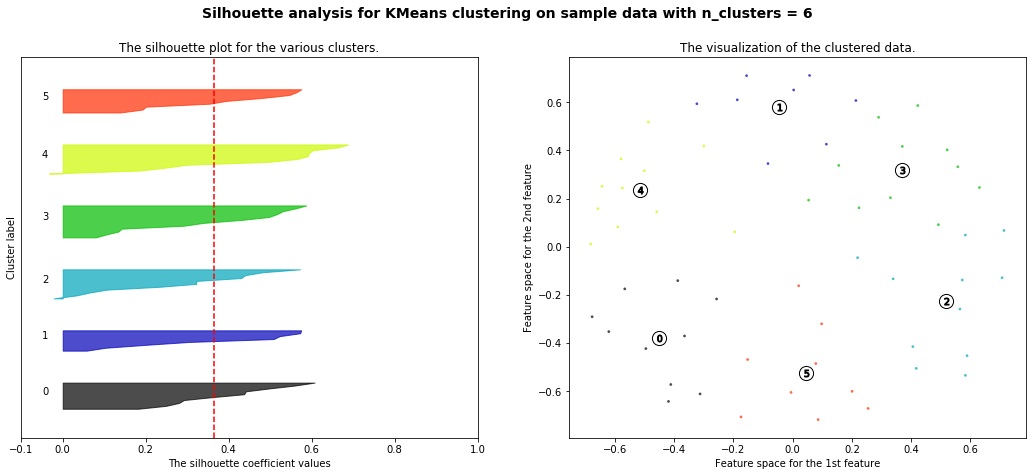

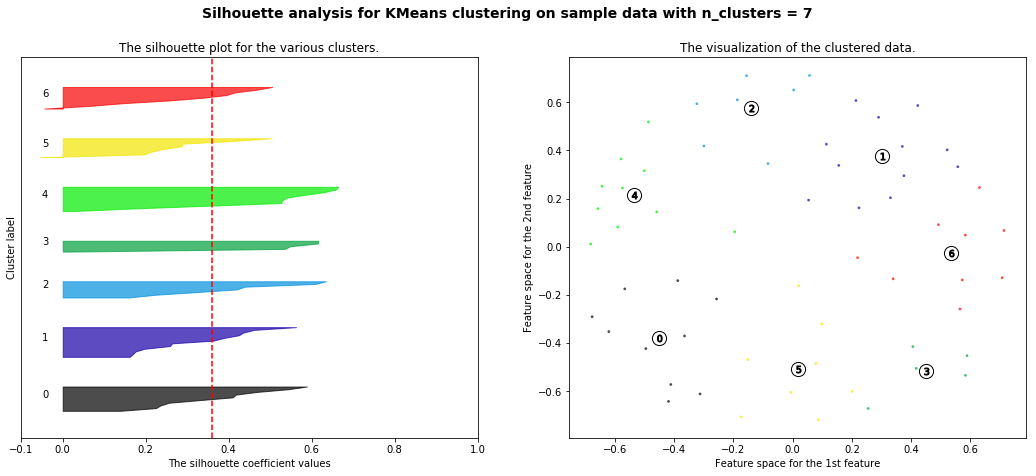

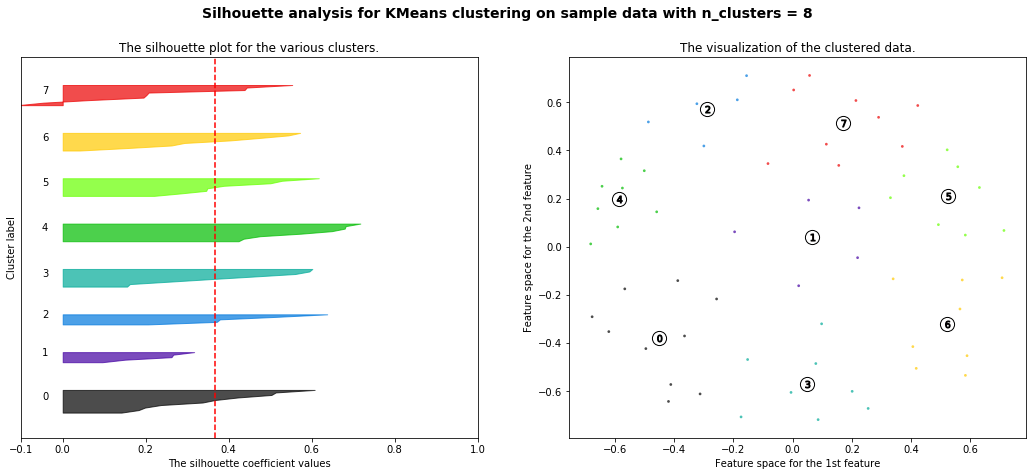

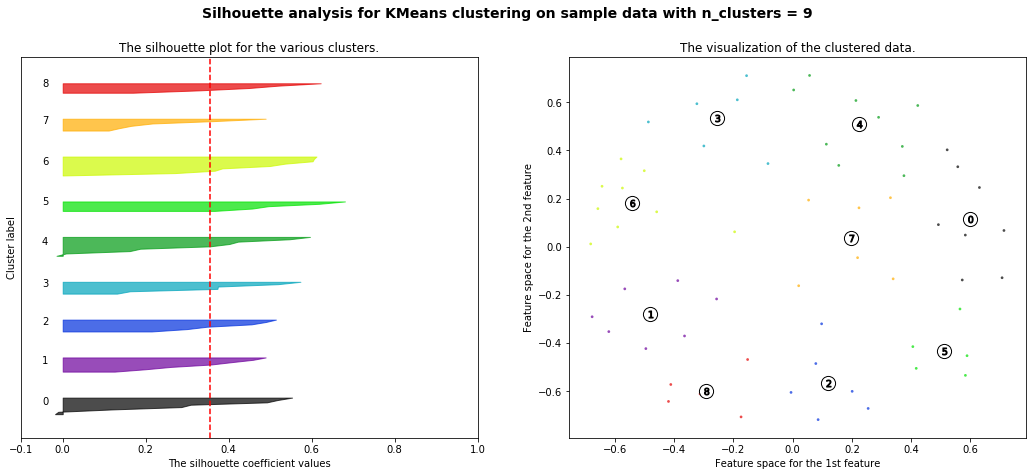

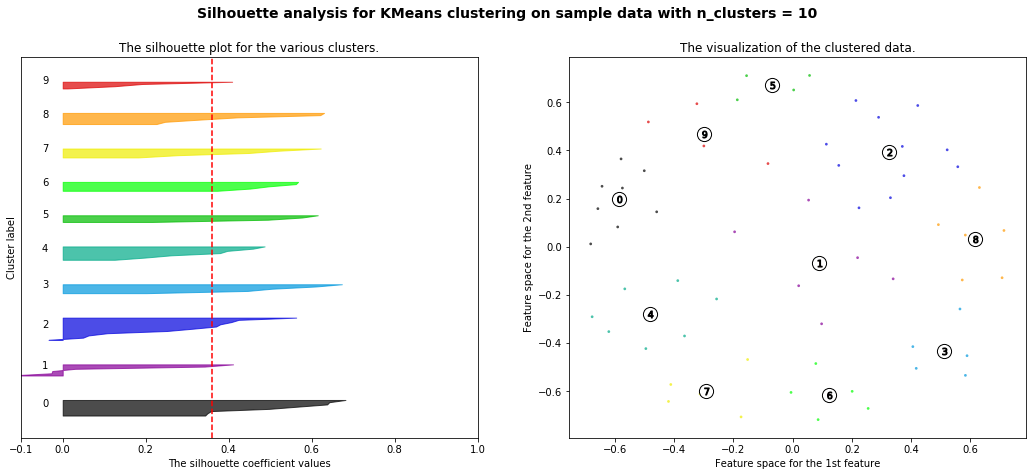

In [46]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

mds = MDS(n_components=2, dissimilarity="precomputed", random_state=10)
dist = 1 - cosine_similarity(TFIDF_matrix)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]


range_n_clusters = [2, 3, 4, 5, 6,7,8,9,10]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(pos) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(pos)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(pos, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(pos, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(pos[:, 0], pos[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

In [115]:
k=7
km = KMeans(n_clusters=k, random_state =89)
km.fit(TFIDF_matrix)
clusters = km.labels_.tolist()


terms = Tfidf.get_feature_names()
Dictionary={'Doc Name':titles, 'Cluster':clusters,  'Text': final_processed_text}
frame=pd.DataFrame(Dictionary, columns=['Cluster', 'Doc Name','Text'])

print("Top terms per cluster:")
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

terms_dict=[]


#save the terms for each cluster and document to dictionaries.  To be used later
#for plotting output.

#dictionary to store terms and titles
cluster_terms={}
cluster_title={}


for i in range(k):
    print("Cluster %d:" % i),
    temp_terms=[]
    temp_titles=[]
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
        terms_dict.append(terms[ind])
        temp_terms.append(terms[ind])
    cluster_terms[i]=temp_terms
    
    print("Cluster %d titles:" % i, end='')
    temp=frame[frame['Cluster']==i]
    for title in temp['Doc Name']:
        print(' %s,' % title, end='')
        temp_titles.append(title)
    cluster_title[i]=temp_titles


Top terms per cluster:
Cluster 0:
 moore
 trump
 economic
 rate
 economy
 powell
 hike
 board
 higher
 increase
Cluster 0 titles: Trump-Plans-to.docx, tephen-Moore_s-Unpaid.docx, Fed-Interest-Rates.docx, The Real Problem with Immigration.docx,Cluster 1:
 shutdown
 trump
 government
 federal
 democrat
 border
 worker
 president
 house
 white
Cluster 1 titles: Shutdown-Unity.docx, Shutdown2.docx, Trumps_ever-shifting_shutdown_Blame_Game.docx, Trump-Puerto-Rico.docx, Trump-to-meet.docx, Republican Senators Discuss Including DACA in Wall Negotiationsgovernment.docx, Shutdown.docx, Totally-bonkers-Trump.docx, JL_Trump Proposes Big Cuts to Health Programs Washington Post.docx, A Republican senator close to President Donald Trump on Sunday backed a temporary re.docx, Trump_Has_Lost_Ground_In_The_Shutdown_Blame_Game.docx, It-May-Take .docx, Government Shutdown Unemployment Claims.docx, Government Shutdown Across America.docx, Trump Approval Rating With Base Drops Amid Shutdown.docx, Trump-walk

# Plotting

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


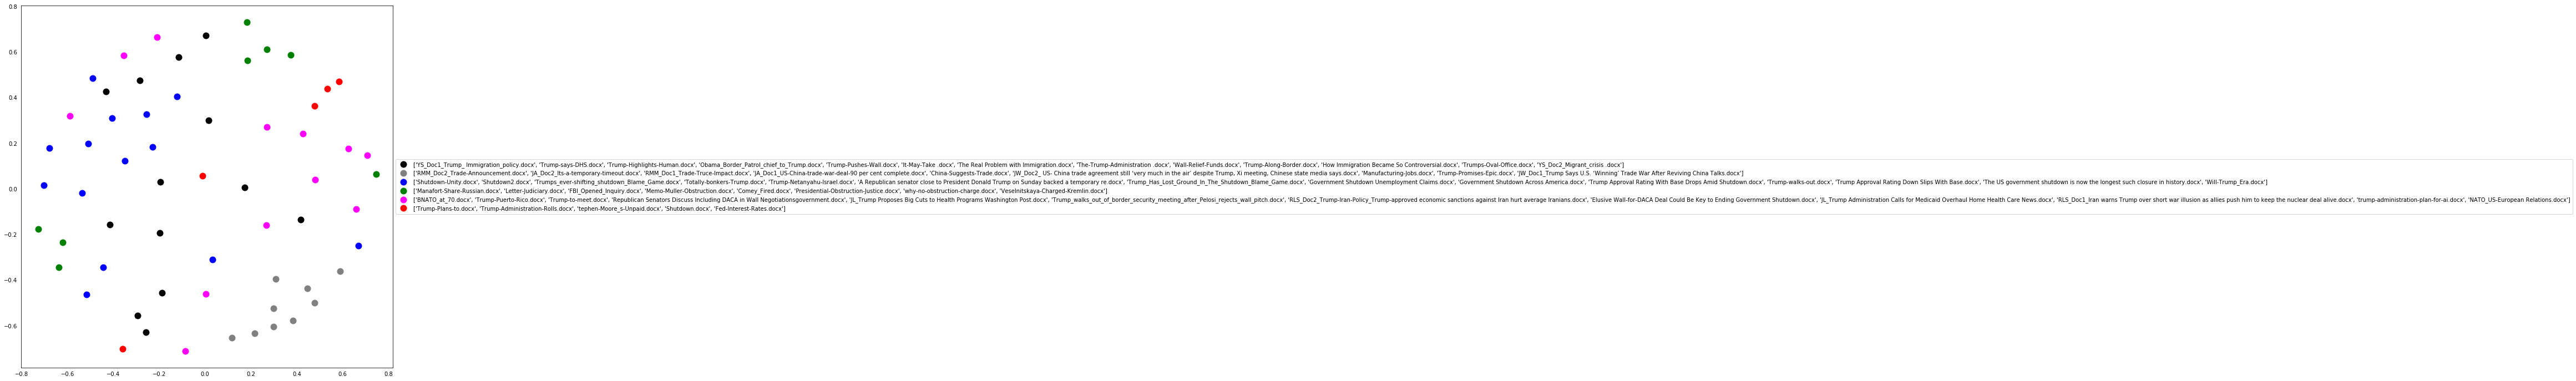

In [39]:
# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.


mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

dist = 1 - cosine_similarity(TFIDF_matrix)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]


#set up colors per clusters using a dict.  number of colors must correspond to K
cluster_colors = {0: 'black', 1: 'grey', 2: 'blue', 3: 'green', 4: 'magenta', 
                  5:'red', 6:'orange', 7:'yellow'}


#set up cluster names using a dict.  
cluster_dict=cluster_title

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=range(0,len(clusters)))) 

#group by cluster
groups = df.groupby('label')

fig, ax = plt.subplots(figsize=(12, 12)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12,
            label=cluster_dict[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='on')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='on')

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))      #show legend with only 1 point



#The following section of code is to run the k-means algorithm on the doc2vec outputs.
#note the differences in document clusters compared to the TFIDF matrix.


#  K Means Clustering Doc2Vec

In [0]:
### K Means Clustering Doc2Vec
###############################################################################
doc2vec_k_means=doc2vec_df.drop('title', axis=1)

k=8
km = KMeans(n_clusters=k, random_state =89)
km.fit(doc2vec_k_means)
clusters_d2v = km.labels_.tolist()

Dictionary={'Doc Name':titles, 'Cluster':clusters_d2v,  'Text': final_processed_text}
frame=pd.DataFrame(Dictionary, columns=['Cluster', 'Doc Name','Text'])

#dictionary to store clusters and respective titles
cluster_title={}

#note doc2vec clusters will not have individual words due to the vector representation
#is based on the entire document not indvidual words. As a result, there won't be individual
#word outputs from each cluster.   
for i in range(k):
    temp=frame[frame['Cluster']==i]
    temp_title_list=[]
    for title in temp['Doc Name']:
        temp_title_list.append(title)
    cluster_title[i]=temp_title_list


# Plotting Doc2vec

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


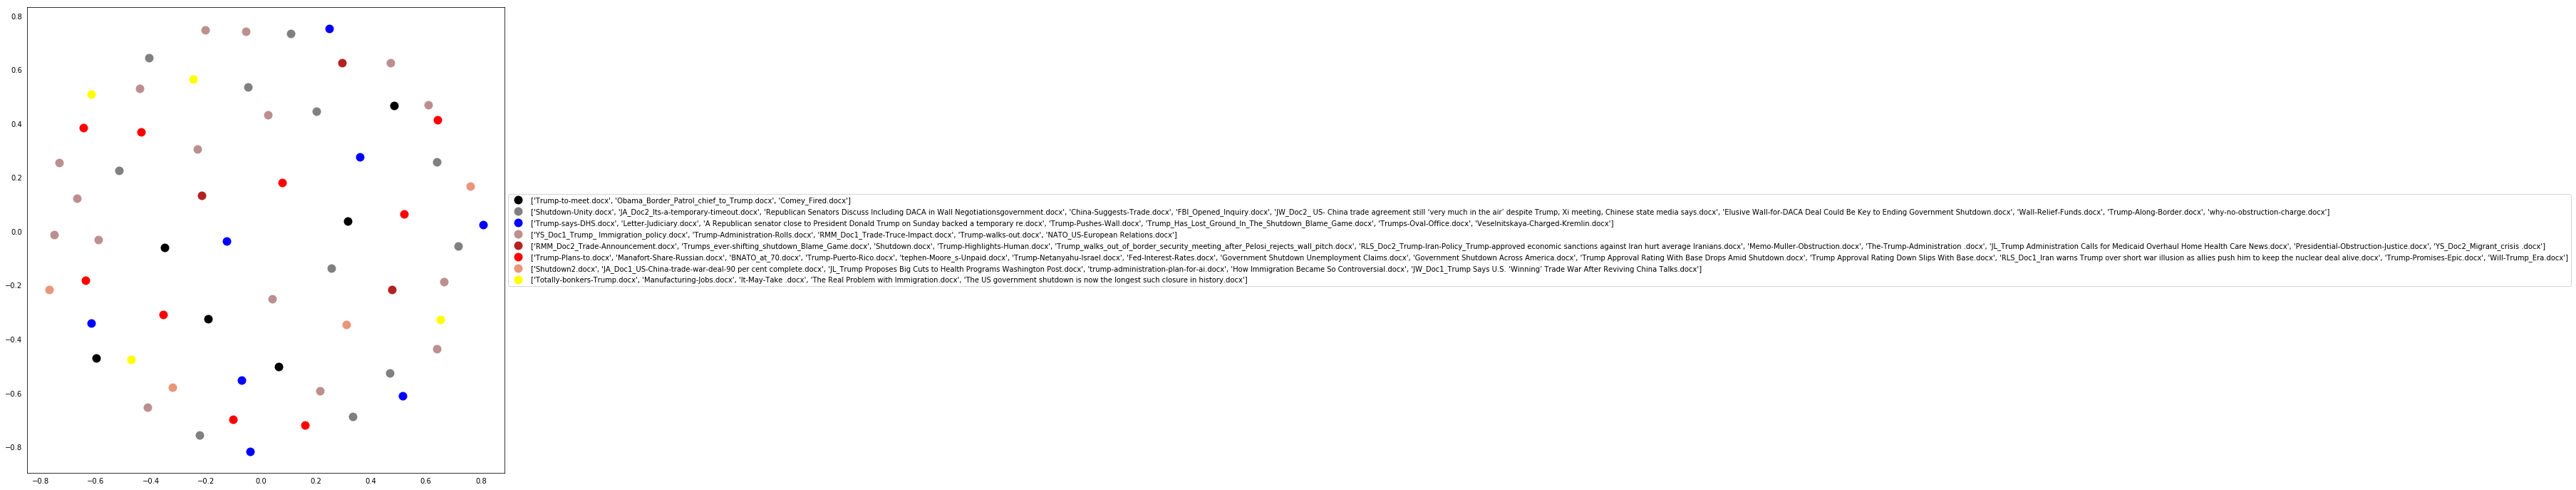

In [0]:
# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.


mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

dist = 1 - cosine_similarity(doc2vec_k_means)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]


#set up colors per clusters using a dict.  number of colors must correspond to K
cluster_colors = {0: 'black', 1: 'grey', 2: 'blue', 3: 'rosybrown', 4: 'firebrick', 
                  5:'red', 6:'darksalmon', 7:'yellow'}


#set up cluster names using a dict.  
cluster_dict=cluster_title         

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=range(0,len(clusters)))) 

#group by cluster
groups = df.groupby('label')

fig, ax = plt.subplots(figsize=(12, 12)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12,
            label=cluster_dict[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='on')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='on')

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))      #show legend with only 1 point


#The following section is used to create a model to predict the clusters labels 
#based on the the TFIDF matrix and the doc2vec vectors.  Note the model performance 
#using the two different vectorization methods.


#Classification using various RF Model

In [173]:
model_RF=RandomForestClassifier()


#TFIDF
Y=clusters
X=TFIDF_matrix

#cross validation
cv_score=cross_val_score(model_RF, X,Y, cv=7)


#mean CV score
np.mean(cv_score)


#Doc2Vec
Y=clusters_d2v
X=doc2vec_k_means

#cross validation
cv_score=cross_val_score(model_RF, X,Y, cv=7)

#mean CV score
np.mean(cv_score)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=7.
  % (min_groups, self.n_splits)), Warning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklear

0.6234126984126984

In [174]:
# fit the model 
model_RF_1=model_RF.fit(X, Y)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


# Get the most important features for classifier 

In [177]:

feature_importances = pd.DataFrame(model_RF_1.feature_importances_,
                                   index = matrix.columns,
                                    columns=['importance']).sort_values('importance',ascending=False) 



feature_importances.loc[feature_importances['importance']>0]


,importance
china,0.046009
russian,0.034434
tariff,0.027670
local control,0.023470
chinese president jinping,0.023252
treaty,0.021557
public,0.016802
system,0.016184
tension,0.016179
administration,0.016080


# Logistic regression 

In [170]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)

cv_score=cross_val_score(clf, X,Y, cv=7)
np.mean(cv_score)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=7.
  % (min_groups, self.n_splits)), Warning)


0.8453823953823953

In [171]:
clf.fit(X, Y)

LogisticRegression(C=30.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=-1,
                   penalty='l2', random_state=40, solver='newton-cg',
                   tol=0.0001, verbose=0, warm_start=False)

In [172]:
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)# sort by first elem, descending order 
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes


importance = get_most_important_features(Tfidf, clf, 40)

KeyError: ignored

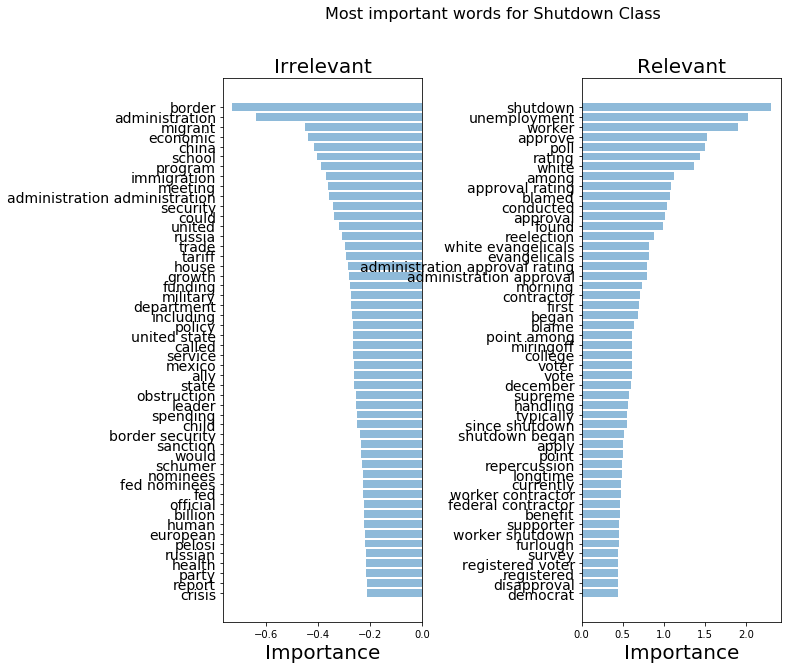

In [146]:
def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 10))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Irrelevant', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Relevant', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()

top_scores = [a[0] for a in importance[1]['tops']]
top_words = [a[1] for a in importance[1]['tops']]
bottom_scores = [a[0] for a in importance[1]['bottom']]
bottom_words = [a[1] for a in importance[1]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for Shutdown Class")

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, stratify =None, random_state=20)


In [0]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)
clf.fit(X_train, y_train)

y_predicted_counts = clf.predict(X_test)

In [34]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.923, precision = 0.942, recall = 0.923, f1 = 0.916


In [0]:
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=10)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=10)
    plt.yticks(tick_marks, classes, fontsize=10)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=10)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)

    return plt

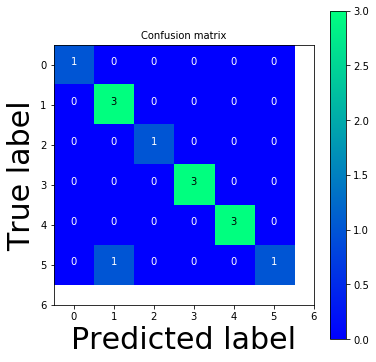

[[1 0 0 0 0 0]
 [0 3 0 0 0 0]
 [0 0 1 0 0 0]
 [0 0 0 3 0 0]
 [0 0 0 0 3 0]
 [0 1 0 0 0 1]]


In [36]:
cm = confusion_matrix(y_test, y_predicted_counts)
fig = plt.figure(figsize=(5, 5))
plot = plot_confusion_matrix(cm, classes=['0','1','2','3','4','5','6'], normalize=False, title='Confusion matrix')
plt.show()
print(cm)

# EC clean up 

In [51]:
Tfidf_check=TfidfVectorizer(ngram_range=(1,3))

TFIDF_matrix_check =Tfidf_check.fit_transform(final_processed_text)  

#creating datafram from TFIDF Matrix
matrix_check =pd.DataFrame(TFIDF_matrix_check.toarray(), columns=Tfidf_check.get_feature_names(), index=titles)

matrix.iloc[1].max() 
matrix_check[['rate']].sort_values(by=['rate'], axis =0, ascending = False)

matrix_check['american country']
matrix_check['force']



,rate
Fed-Interest-Rates.docx,0.146248
JW_Doc1_Trump Says U.S. ‘Winning’ Trade War After Reviving China Talks.docx,0.083705
Trump-Plans-to.docx,0.055981
Trump-walks-out.docx,0.030645
The Real Problem with Immigration.docx,0.025944
RMM_Doc2_Trade-Announcement.docx,0.025197
Wall-Relief-Funds.docx,0.000000
RLS_Doc2_Trump-Iran-Policy_Trump-approved economic sanctions against Iran hurt average Iranians.docx,0.000000
Government Shutdown Unemployment Claims.docx,0.000000
Memo-Muller-Obstruction.docx,0.000000


In [0]:
def create_ec(dictionary, corpus):
    for key, values in dictionary.items():
        for value in values:
          for i in range(len(corpus)):
            corpus[i]= corpus[i].replace(value, key)
    return corpus

corpus= final_processed_text


list = [{'administration': ['cabinet','president','trump','donald','president donald','donald trump','president trump','president donald trump','trump administration','white house','washington']},
        {'migrant': ['refugee','immigrant', 'newcomer','alien','undocumented','fugitive','asylum seeker','fugitive alien','undocumented alien','illegal alien']}, 
            {'wall': ['barrier', 'fencing', 'steel barrier', 'concrete wall']}, 
            {'shutdown': ['government shutdown','partial shutdown','partial government shutdown', 'partial closure of government']},
            {'worker':['government employee', 'federal worker', 'government worker', 'federal employee', 'emplyee']},
            {'contractor':['worker contractor', 'federal contractor']},
            {'raid': ['immigration crackdown']}, 
            {'mexico border': ['southern border', 'southwestern border', 'mexico border', 'us mexico border']}, 
            #{'rate': ['interest rate']}, 
            {'increase':['hike']},
            {'nominees': ['herman cain', 'stephen moore', 'cain','moore', 'fed nominees']}, 
            {'mueller': ['special counsel', 'counsel','robert mueller']},
            {'tower': ['trump tower']}, 
            {'russia': ['russian government', 'kremlin', 'russian administration']}, 
            {'clinton': ['hilary clinton']}, 
            {'comey': ['james comey']}, 
            {'assistance': ['medicaid', 'medicare', 'foodstamp', 'assistance program', 'program']}, 
            {'rating':['approval rating', 'administration approval rating', 'administration approval']}, 
            {'iran': ['islamic republic']}, 
            {'military':['armed force']}, 
            {'journal': ['street journal']}]

for dic in list:
   corpus_new = create_ec(dic, corpus)
    
list[1].items()
  
Tfidf_2=TfidfVectorizer(ngram_range=(1,3), min_df = 0.03)

TFIDF_matrix_2 =Tfidf_2.fit_transform(corpus_new)  

#creating datafram from TFIDF Matrix
matrix_2=pd.DataFrame(TFIDF_matrix_2.toarray(), columns=Tfidf_2.get_feature_names(), index=titles)



# K Means Clustering - corpus_new


For n_clusters = 2 The average silhouette_score is : 0.35116810902588413
For n_clusters = 3 The average silhouette_score is : 0.39701580256423835
For n_clusters = 4 The average silhouette_score is : 0.4071683522323933
For n_clusters = 5 The average silhouette_score is : 0.39637332315145624
For n_clusters = 6 The average silhouette_score is : 0.3728557506475893
For n_clusters = 7 The average silhouette_score is : 0.3864237487831148
For n_clusters = 8 The average silhouette_score is : 0.38652383921481015
For n_clusters = 9 The average silhouette_score is : 0.35321393418531394
For n_clusters = 10 The average silhouette_score is : 0.35667126897943513


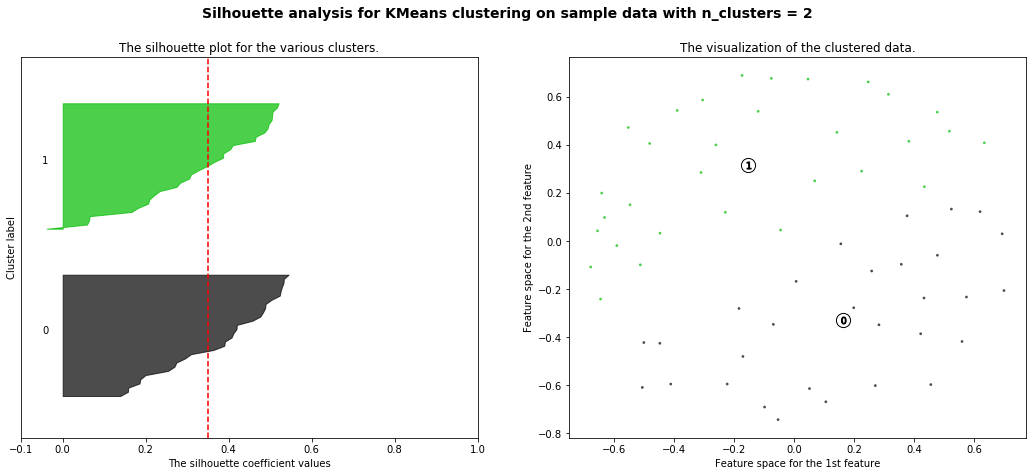

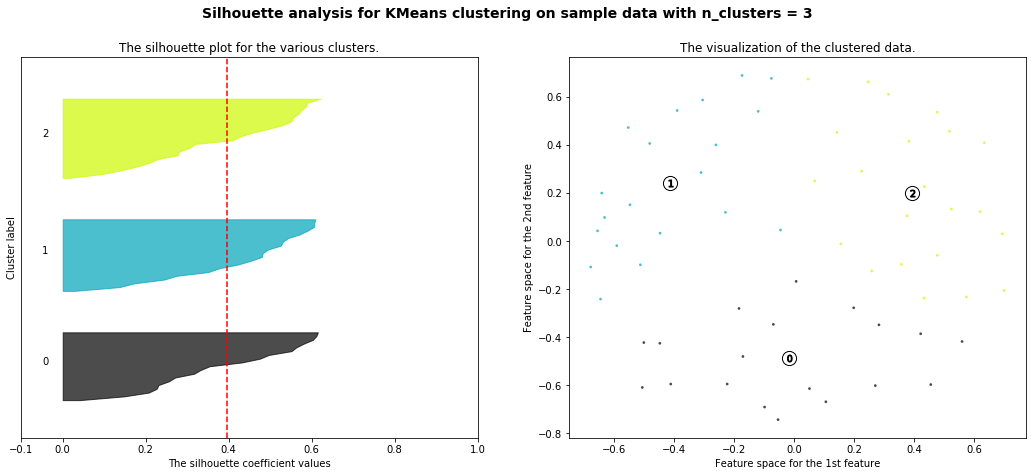

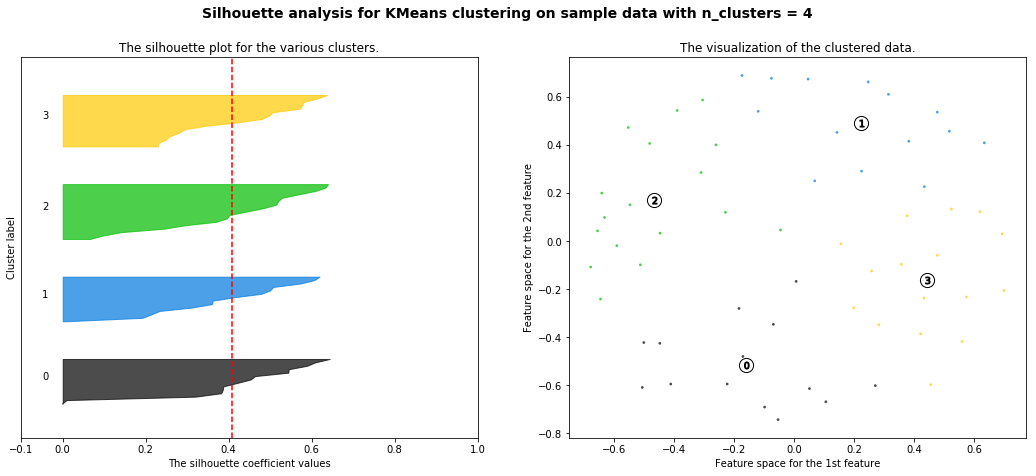

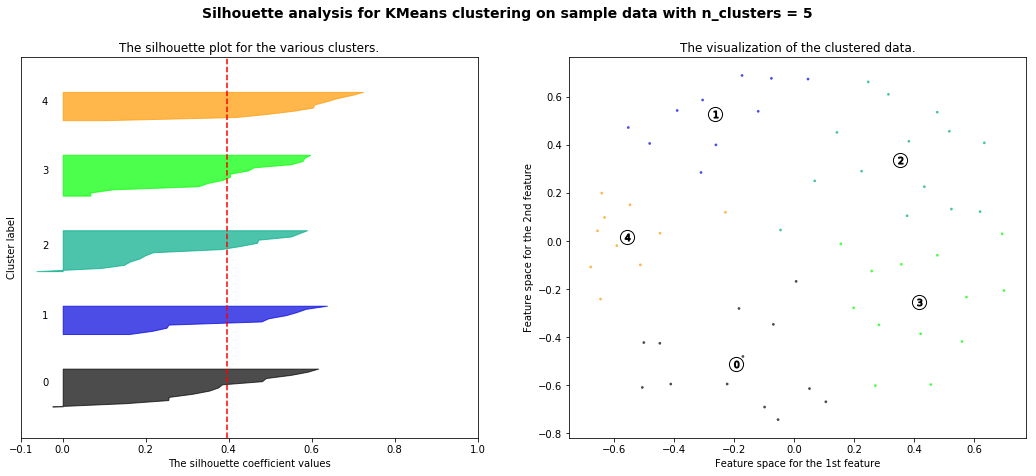

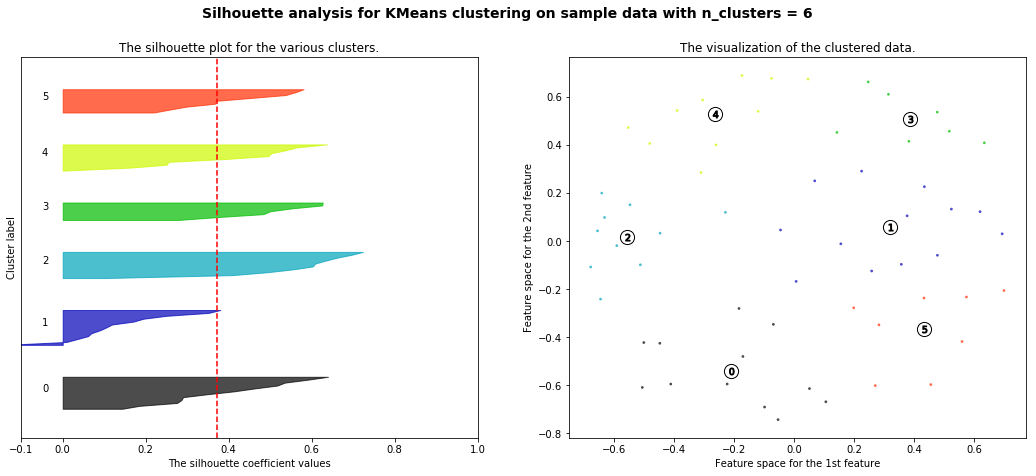

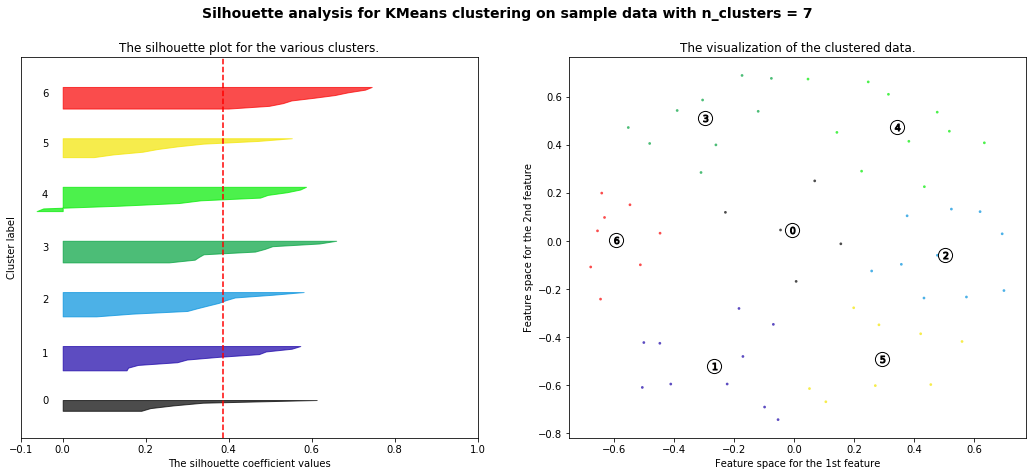

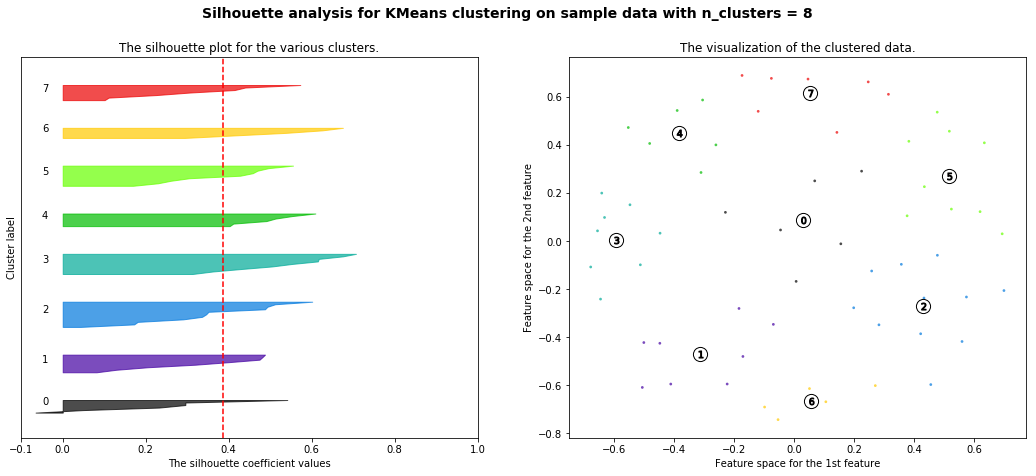

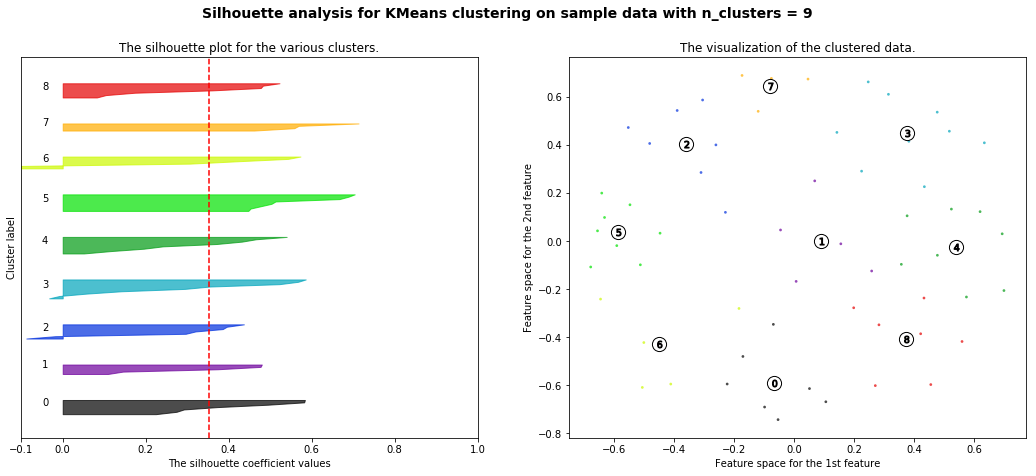

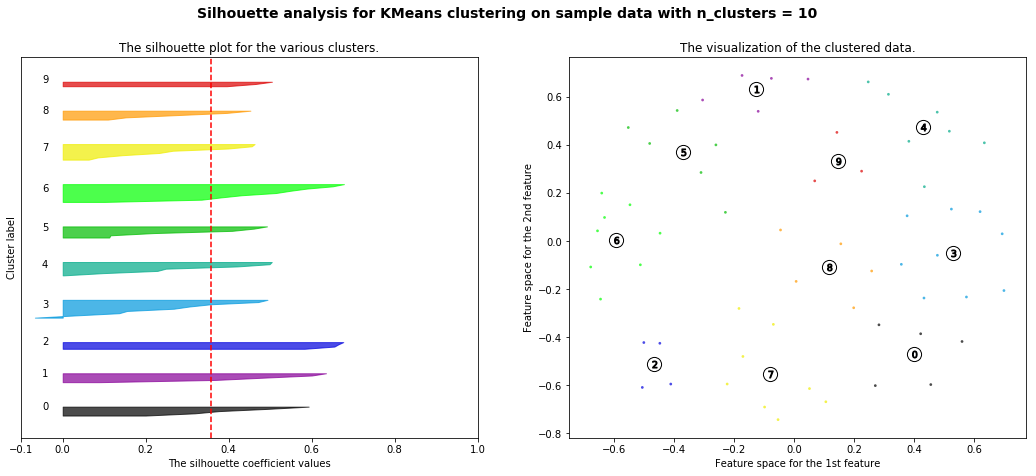

In [236]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

mds = MDS(n_components=2, dissimilarity="precomputed", random_state=10)
dist = 1 - cosine_similarity(TFIDF_matrix_2)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]


range_n_clusters = [2, 3, 4, 5, 6,7,8,9,10]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(pos) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(pos)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(pos, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(pos, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(pos[:, 0], pos[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

In [53]:
k=7
km = KMeans(n_clusters=k, random_state = 118)
km.fit(TFIDF_matrix_2)
clusters = km.labels_.tolist()


terms = Tfidf_2.get_feature_names()
Dictionary={'Doc Name':titles, 'Cluster':clusters,  'Text': corpus_new}
frame=pd.DataFrame(Dictionary, columns=['Cluster', 'Doc Name','Text'])

print("Top terms per cluster:")
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

terms_dict=[]


#save the terms for each cluster and document to dictionaries.  To be used later
#for plotting output.

#dictionary to store terms and titles
cluster_terms={}
cluster_title={}


for i in range(k):
    print("Cluster %d:" % i),
    temp_terms=[]
    temp_titles=[]
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
        terms_dict.append(terms[ind])
        temp_terms.append(terms[ind])
    cluster_terms[i]=temp_terms
    
    print("Cluster %d titles:" % i, end='')
    temp=frame[frame['Cluster']==i]
    for title in temp['Doc Name']:
        print(' %s,' % title, end='')
        temp_titles.append(title)
    cluster_title[i]=temp_titles

frame.groupby('Cluster').count()




Top terms per cluster:
Cluster 0:
 nominees
 administration
 increase
 rate
 powell
 board
 december
 interest increase
 nomination
 announced
Cluster 0 titles: Trump-Plans-to.docx, tephen-Moore_s-Unpaid.docx, Fed-Interest-Rates.docx,Cluster 1:
 migrant
 family
 immigration
 child
 administration
 border
 nielsen
 separated
 asylum
 raid
Cluster 1 titles: YS_Doc1_Trump_ Immigration_policy.docx, Trump-says-DHS.docx, It-May-Take .docx, The Real Problem with Immigration.docx, The-Trump-Administration .docx, How Immigration Became So Controversial.docx, YS_Doc2_Migrant_crisis .docx,Cluster 2:
 china
 administration
 tariff
 chinese
 trade
 huawei
 company
 talk
 agreed
 agreement
Cluster 2 titles: RMM_Doc2_Trade-Announcement.docx, JA_Doc2_Its-a-temporary-timeout.docx, RMM_Doc1_Trade-Truce-Impact.docx, JA_Doc1_US-China-trade-war-deal-90 per cent complete.docx, China-Suggests-Trade.docx, JW_Doc2_ US- China trade agreement still ‘very much in the air’ despite Trump, Xi meeting, Chinese state 

,Doc Name,Text
Cluster,,
0,3,3
1,7,7
2,12,12
3,16,16
4,8,8
5,2,2
6,13,13


# Plotting

In [228]:
# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.


mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

dist = 1 - cosine_similarity(TFIDF_matrix)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]


#set up colors per clusters using a dict.  number of colors must correspond to K
cluster_colors = {0: 'black', 1: 'grey', 2: 'blue', 3: 'green', 4: 'magenta', 
                  5:'red', 6:'orange', 7:'yellow'}


#set up cluster names using a dict.  
cluster_dict=cluster_title

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=range(0,len(clusters)))) 

#group by cluster
groups = df.groupby('label')

fig, ax = plt.subplots(figsize=(12, 12)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12,
            label=cluster_dict[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='on')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='on')

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))      #show legend with only 1 point



#The following section of code is to run the k-means algorithm on the doc2vec outputs.
#note the differences in document clusters compared to the TFIDF matrix.


{0: ['Trump-Puerto-Rico.docx',
  'Trump-to-meet.docx',
  'JL_Trump Proposes Big Cuts to Health Programs Washington Post.docx',
  'JL_Trump Administration Calls for Medicaid Overhaul Home Health Care News.docx',
  'trump-administration-plan-for-ai.docx'],
 1: ['RMM_Doc2_Trade-Announcement.docx',
  'JA_Doc2_Its-a-temporary-timeout.docx',
  'RMM_Doc1_Trade-Truce-Impact.docx',
  'JA_Doc1_US-China-trade-war-deal-90 per cent complete.docx',
  'China-Suggests-Trade.docx',
  'JW_Doc2_ US- China trade agreement still ‘very much in the air’ despite Trump, Xi meeting, Chinese state media says.docx',
  'Manufacturing-Jobs.docx',
  'Trump-Promises-Epic.docx',
  'JW_Doc1_Trump Says U.S. ‘Winning’ Trade War After Reviving China Talks.docx'],
 2: ['YS_Doc1_Trump_ Immigration_policy.docx',
  'Trump-says-DHS.docx',
  'Trump-Administration-Rolls.docx',
  'Obama_Border_Patrol_chief_to_Trump.docx',
  'Trump-Pushes-Wall.docx',
  'It-May-Take .docx',
  'The Real Problem with Immigration.docx',
  'The-Trump-A

# Logistic regression. Corpus New


In [0]:
model_RF_2=RandomForestClassifier()

#TFIDF
Y=clusters
X=TFIDF_matrix_2

#cross validation
cv_score=cross_val_score(model_RF_2, X,Y, cv=7)


#mean CV score
np.mean(cv_score)


In [214]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)

cv_score=cross_val_score(clf, X,Y, cv=7)
np.mean(cv_score)



/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=7.
  % (min_groups, self.n_splits)), Warning)


0.7849947671376242

In [215]:
clf.fit(X, Y)

LogisticRegression(C=30.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='multinomial', n_jobs=-1,
                   penalty='l2', random_state=40, solver='newton-cg',
                   tol=0.0001, verbose=0, warm_start=False)

In [0]:
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)# sort by first elem, descending order 
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes


importance = get_most_important_features(Tfidf_2, clf, 50)

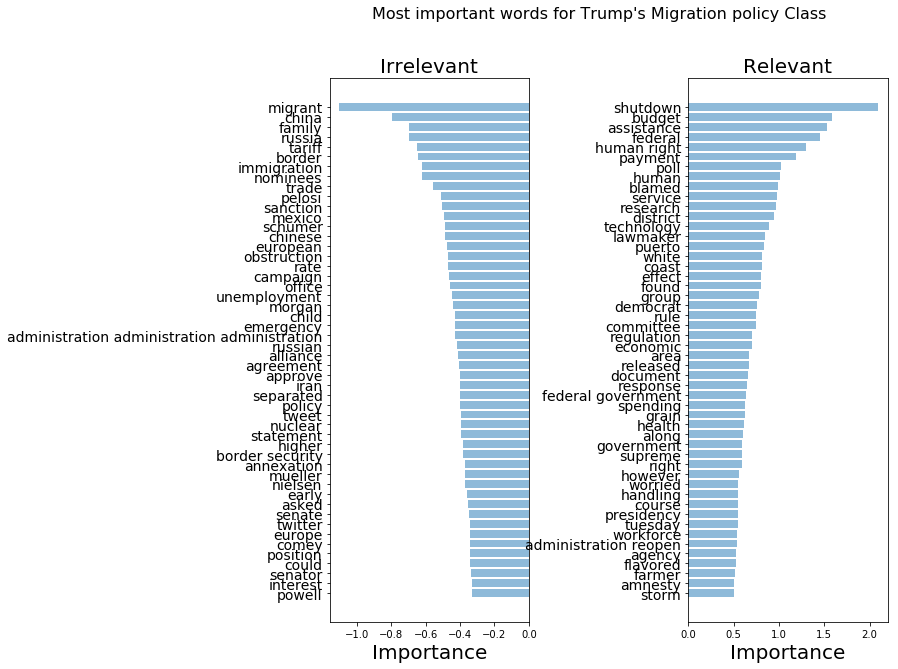

In [217]:
def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 10))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Irrelevant', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Relevant', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()

top_scores = [a[0] for a in importance[5]['tops']]
top_words = [a[1] for a in importance[5]['tops']]
bottom_scores = [a[0] for a in importance[5]['bottom']]
bottom_words = [a[1] for a in importance[5]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for Trump's Migration policy Class")

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, stratify =None, random_state=20)


In [0]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1, random_state=40)
clf.fit(X_train, y_train)

y_predicted_counts = clf.predict(X_test)

In [0]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

In [0]:
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=10)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=10)
    plt.yticks(tick_marks, classes, fontsize=10)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] < thresh else "black", fontsize=10)
    
    plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)

    return plt

In [0]:
cm = confusion_matrix(y_test, y_predicted_counts)
fig = plt.figure(figsize=(5, 5))
plot = plot_confusion_matrix(cm, classes=['0','1','2','3','4','5','6'], normalize=False, title='Confusion matrix')
plt.show()
print(cm)

#LDA Code

In [257]:
def create_ec_2(dictionary, corpus):
    for key, values in dictionary.items():
        for value in values:
          for i in range(len(corpus)):
             for j in range(len(corpus[i])):
                if corpus[i][j] == value:
                  corpus[i][j] == key
    return corpus

corpus_2= processed_text


list = [{'administration': ['cabinet','president','trump','donald','president donald','donald trump','president trump','president donald trump','trump administration','white house','washington']},
        {'migrant': ['refugee','immigrant', 'newcomer','alien','undocumented','fugitive','asylum seeker','fugitive alien','undocumented alien','illegal alien']}, 
            {'wall': ['barrier', 'fencing', 'steel barrier', 'concrete wall']}, 
            {'shutdown': ['government shutdown','partial shutdown','partial government shutdown', 'partial closure of government']},
            {'worker':['government employee', 'federal worker', 'government worker', 'federal employee', 'emplyee']},
            {'contractor':['worker contractor', 'federal contractor']},
            {'raid': ['immigration crackdown']}, 
            {'mexico border': ['southern border', 'southwestern border', 'mexico border', 'us mexico border']}, 
            {'rate': ['interest rate']}, 
            {'increase':['hike']},
            {'nominees': ['herman cain', 'stephen moore', 'cain','moore', 'fed nominees']}, 
            {'mueller': ['special counsel', 'counsel','robert mueller']},
            {'tower': ['trump tower']}, 
            {'russia': ['russian government', 'kremlin', 'russian administration']}, 
            {'clinton': ['hilary clinton']}, 
            {'comey': ['james comey']}, 
            {'assistance': ['medicaid', 'medicare', 'foodstamp', 'assistance program', 'program']}, 
            {'rating':['approval rating', 'administration approval rating', 'administration approval']}, 
            {'iran': ['islamic republic']}, 
            {'military':['armed force']}, 
            {'journal': ['street journal']}]

for dic in list:
   corpus_new_2= create_ec_2(dic, corpus_2)

[['president',
  'donald',
  'trump',
  'republican',
  'totally',
  'unified',
  'behind',
  'border',
  'fight',
  'president',
  'senate',
  'caucus',
  'senator',
  'started',
  'break',
  'party',
  'trump',
  'immigration',
  'battle',
  'trump',
  'senator',
  'emerged',
  'preaching',
  'consensus',
  'shutdown',
  'ending',
  'anytime',
  'democrat',
  'pledge',
  'proposed',
  'barrier',
  'behind',
  'president',
  'think',
  'border',
  'security',
  'issue',
  'extremely',
  'important',
  'country',
  'senate',
  'majority',
  'leader',
  'mitch',
  'mcconnell',
  'reporter',
  'meeting',
  'reopen',
  'federal',
  'department',
  'appeared',
  'shape',
  'stalemate',
  'continues',
  'trump',
  'bipartisan',
  'congressional',
  'leader',
  'including',
  'house',
  'speaker',
  'nancy',
  'pelosi',
  'senate',
  'minority',
  'leader',
  'chuck',
  'schumer',
  'democraticheld',
  'house',
  'passed',
  'legislation',
  'government',
  'money',
  'proposed',
  'mcconnel

Gensim creates a unique id for each word in the document. The produced corpus shown above is a mapping of (word_id, word_frequency).
https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [266]:
###############################################################################
###  LDA Code
###############################################################################

#LDA using bag of words
dictionary = corpora.Dictionary(processed_text)
corpus = [dictionary.doc2bow(doc) for doc in corpus_new_2] #Convert document (a list of words) 
#into the bag-of-words format = list of (token_id, token_count) 2-tuples
ldamodel = LdaMulticore(corpus, num_topics=9, id2word=dictionary, passes=2, workers=2)   

# Human readable format of corpus (term-frequency)
[[(dictionary[id], freq) for id, freq in cp] for cp in corpus[:1]]

#You can see the keywords for each topic and 
#the weightage(importance) of each keyword using lda_model.print_topics() as shown next:
for idx, topic in ldamodel.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))


#LDA using TFIDF
tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]
ldamodel = LdaMulticore(corpus_tfidf, num_topics=7, id2word=dictionary, passes=2, workers=2)    

for idx, topic in ldamodel.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))
    
    

Topic: 0 
Words: 0.001*"raid" + 0.001*"mueller" + 0.001*"obstruction" + 0.001*"truce" + 0.001*"asylum" + 0.001*"justice" + 0.001*"planned" + 0.001*"standard" + 0.001*"attorney" + 0.001*"conclusion"
Topic: 1 
Words: 0.002*"china" + 0.001*"huawei" + 0.001*"chinese" + 0.001*"nielsen" + 0.001*"trade" + 0.001*"morgan" + 0.001*"tariff" + 0.001*"border" + 0.001*"school" + 0.001*"economy"
Topic: 2 
Words: 0.001*"school" + 0.001*"shutdown" + 0.001*"rating" + 0.001*"definitely" + 0.001*"approve" + 0.001*"immigration" + 0.001*"poll" + 0.001*"immigrant" + 0.001*"approval" + 0.001*"comey"
Topic: 3 
Words: 0.001*"tariff" + 0.001*"china" + 0.001*"moore" + 0.001*"growth" + 0.001*"chinese" + 0.001*"economic" + 0.001*"capps" + 0.001*"manufacturing" + 0.001*"shutdown" + 0.001*"company"
Topic: 4 
Words: 0.001*"emergency" + 0.001*"border" + 0.001*"pelosi" + 0.001*"shutdown" + 0.001*"democrat" + 0.001*"senate" + 0.001*"golan" + 0.001*"nuclear" + 0.001*"child" + 0.001*"graham"
Topic: 5 
Words: 0.001*"militar

# Perplexity and Coherence Score 
Model perplexity and topic coherence provide a convenient measure to judge how good a given topic model is. In my experience, topic coherence score, in particular, has been more helpful. 
Quantitative measure of quality of topics' segmentation. 
https://datascienceplus.com/evaluation-of-topic-modeling-topic-coherence/


In [267]:
# Compute Perplexity
print('\nPerplexity: ', ldamodel.log_perplexity(corpus_tfidf))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=ldamodel, texts=processed_text, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -12.199463454353888

Coherence Score:  0.4645644152844285


#Finding the best k value for LDA model using Bag of words 
Choosing a ‘k’ that marks the end of a rapid growth of topic coherence usually offers meaningful and interpretable topics.

In [0]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=LdaMulticore(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=processed_text, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [241]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=processed_text, start=2, limit=10, step=1)
# Show graph
import matplotlib.pyplot as plt
limit=10; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

NameError: ignored

# Finding the optimal number of topics using coherence score and TFIDF 

In [0]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=LdaMulticore(corpus=corpus_tfidf, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=processed_text, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [239]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus_tfidf, texts=processed_text, start=2, limit=10, step=1)
# Show graph
import matplotlib.pyplot as plt
limit=10; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

NameError: ignored

# Visualize the topics

In [0]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
vis

#Fine tune the model 

In [37]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
# Define Search Param
search_params = {'n_components': [7], 'learning_decay': [.1, .5, .7, .9],'batch_size':[16,32,64,128,200]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(TFIDF_matrix)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='batch',
                                                 learning_offset=10.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=10,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=None,
                                                 perp_tol=0.1,
                                                 random_state=None,
                                                 topic_word_prior=None,
                                   

In [39]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(TFIDF_matrix))

Best Model's Params:  {'batch_size': 64, 'learning_decay': 0.1, 'n_components': 7}
Best Log Likelihood Score:  -2896.0273657999555
Model Perplexity:  77369.15412989925


In [40]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(TFIDF_matrix)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(data))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=titles)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if type(val) == int else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,dominant_topic
Shutdown-Unity.docx,0.01,0.94,0.01,0.01,0.01,0.01,0.01,1
YS_Doc1_Trump_ Immigration_policy.docx,0.01,0.93,0.01,0.01,0.01,0.01,0.01,1
Trump-Plans-to.docx,0.87,0.01,0.01,0.01,0.08,0.01,0.01,0
Manafort-Share-Russian.docx,0.01,0.01,0.01,0.01,0.01,0.01,0.92,6
Trump-says-DHS.docx,0.01,0.01,0.5,0.01,0.43,0.01,0.01,2
Shutdown2.docx,0.01,0.63,0.01,0.32,0.01,0.01,0.01,1
RMM_Doc2_Trade-Announcement.docx,0.01,0.01,0.01,0.01,0.92,0.01,0.01,4
Trump-Administration-Rolls.docx,0.82,0.02,0.02,0.02,0.1,0.02,0.02,0
BNATO_at_70.docx,0.01,0.01,0.01,0.01,0.92,0.01,0.01,4
Trumps_ever-shifting_shutdown_Blame_Game.docx,0.01,0.92,0.01,0.01,0.01,0.01,0.01,1


In [41]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,4,23
1,1,14
2,6,9
3,0,6
4,3,5
5,2,3
6,5,1


# LDA Prediction


In [287]:
from google.colab import files 
uploaded = files.upload()
!ls

Saving corpus_test_bert_tsv.csv to corpus_test_bert_tsv.csv
2019_Summer_435_Class_Corpus.csv  corpus_test_bert_tsv.csv  sample_data


In [15]:
#read in class corpus csv into python
test=pd.read_csv('corpus_test_bert_tsv.csv')
test.head()

,ID,Text
0,1,"Each year, the U.S. gets about 1,000 applicati..."
1,2,Democrats torched President Donald Trump as a ...
2,3,The public’s views of the nation’s economy hav...
3,4,Democratic presidential candidate Beto O’Rourk...
4,5,WASHINGTON — The Senate Intelligence Committee...


In [0]:
test_body=[]

#for loop which appends the text to the text_body list
for i in range(0,len(test)):
    temp_text=data['Text'].iloc[i]
    test_body.append(temp_text)

#Note: the text_body is the unprocessed list of documents read directly form 
#the csv.
    
#empty list to store processed documents
processed_test=[]
#for loop to process the text to the processed_text list
for i in test_body:
    text=clean_doc(i)
    processed_test.append(text)

final_processed_test=[]

for i in processed_test:
    temp_DSI=i[0]
    for k in range(1,len(i)):
        temp_DSI=temp_DSI+' '+i[k]
    final_processed_test.append(temp_DSI)

In [0]:
#fit the vectorizer using final processed documents.  The vectorizer requires the 
#stiched back together document.

TFIDF_matrix_test=Tfidf.fit_transform(final_processed_test)  


#creating datafram from TFIDF Matrix
matrix_test=pd.DataFrame(TFIDF_matrix_test.toarray(), columns=Tfidf.get_feature_names())


In [48]:
# Define function to predict topic for a given text document.
# Define function to predict topic for a given text document.
nlp = spacy.load('en', disable=['parser', 'ner'])

# Define function to predict topic for a given text document.
nlp = spacy.load('en', disable=['parser', 'ner'])
def predict_topic(text, nlp=nlp):
   # Step 1: LDA Transform
    topic_probability_scores = best_lda_model.fit(text)
    topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), 1:14].values.tolist()
    
    # Step 2: Infer Topic
    infer_topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), -1]
    
    #topic_guess = df_topic_keywords.iloc[np.argmax(topic_probability_scores), Topics]
    return infer_topic, topic, topic_probability_scores
  
  
mytext = ["Very Useful in diabetes age 30. I need control sugar. thanks Good deal"]
infer_topic, topic, prob_scores = predict_topic(text = mytext)
print(topic)
print(infer_topic)  

predict_topic(TFIDF_matrix_test)
def apply_predict_topic(text):
 text = text
 infer_topic, topic, prob_scores = predict_topic(text = text)
 return(infer_topic)
predict_topic(TFIDF_matrix_test)
df.head()

df["Topic_key_word"]= df['Translated_Review'].apply(apply_predict_topic)
df.head()
!ls

NameError: ignored

In [0]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', OneVsRestClassifier(MultinomialNB(
        fit_prior=True, class_prior=None))),
])
parameters = {
    'tfidf__max_df': (0.25, 0.5, 0.75),
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'clf__estimator__alpha': (1e-2, 1e-3)
}

grid_search_tune = GridSearchCV(pipeline, parameters, cv=2, n_jobs=2, verbose=3)
TFIDF_matrix_2=tfidf.fit_transform(final_processed_text) 
grid_search_tune.fit(TFIDF_matrix_2, Y)

print("Best parameters set:")
print (grid_search_tune.best_estimator_.steps)